In [65]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Flatten, concatenate, Reshape
from tensorflow import keras
from keras import callbacks
import glob
import tensorflow.python.keras.backend as K
import os

In [106]:
# Load dataset
files = glob.glob("/uufs/chpc.utah.edu/common/home/rott-group3/xray_training/trials_*.npy")
keys = ['E', 'rate', 'pars']
datasets = []
data = {}
for file in files:
    datasets.append(np.load(file, allow_pickle=True).tolist())
    
data=combine_dict(datasets[1], datasets[0])
data=combine_dict(data, datasets[2])


# Split into train and test sets
train_size = int(len(data['E']) * 0.8)
for key in keys:
    train_data, test_data = data[key][:train_size], data[key][train_size:]

In [108]:
len(data['E'])

4000

In [109]:
def combine_dict(d1, d2):

    return {
        k: d1[k] + d2[k]
        for k in set(d1.keys()) | set(d2.keys())
    }

In [110]:
df=pd.DataFrame(data)
#df.to_pickle('pd.pkl')
#df = pd.read_pickle('pd.pkl')

In [112]:
insts = ["FPMA", "FPMB", "pn", "m1", "m2"]
# using assign() and passing address list as parameter
# cut length
ns = [20, 20, 80, 20, 20]
exp = [3600, #mean exposure across field
        3600,
        2490,
        2490,
        2490]
for i, inst in enumerate(insts):
    df_e, df_r = [],[]
    for e, r in zip(df['E'], df['rate']):
        df_e.append(e[i][:ns[i]])
        df_r.append(r[i][:ns[i]])

    df['E_'+inst] = df_e
    df['rate_'+inst] = df_r

In [113]:
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

In [136]:
label_keys = list(train_data['pars'][0].keys())[1::]

In [156]:
label_keys

['torsigma', 'ctkcover', 'nh', 'theta_inc', 'phoindex', 'z']

In [154]:
def create_sequences(data, seq_length):
    X = [data['E_'+inst].tolist() for inst in insts]
    y = [data['rate_'+inst].tolist() for inst in insts]

    l = []

    for data_i in data['pars']:
        ls = [float(data_i[k]) for k in label_keys]
        l.append(ls)
    for i in range(5):
        X[i] = np.array(X[i]).reshape((len(X[i]), ns[i], 1))
        y[i] = np.array(y[i]).reshape((len(y[i]), ns[i],1))

    return X, y, np.array(l)

# Define sequence length
seq_length = 1

# Create sequences for training set
X_train, y_train, l_train = create_sequences(train_data, seq_length)
# Create sequences for testing set
X_test, y_test, l_test = create_sequences(test_data, seq_length)


In [155]:
l_test[0]

array([39.23174255,  0.52238993, 23.89098161, 74.38462483,  2.05332119,
        0.17459796])

In [157]:
input1 = Input(shape=(ns[0],1))
x1 = LSTM(32, activation="tanh", return_sequences=True)(input1)

input2 = Input(shape=(ns[1],1))
x2 = LSTM(32, activation="tanh", return_sequences=True)(input2)

# normally we have more than 1 hidden layer
#flat_x1 = Flatten()(x1)
#flat_x2 = Flatten()(x2)

dense = concatenate([x1 ,x2], axis=-1)
#dense = LSTM(units=128, activation="tanh", return_sequences=True)(concat)
dense = Dense(units = 64)(dense) 
dense1 = Flatten()(dense)

input3 = Input(shape=(ns[2],1))
x3 = LSTM(128, activation="tanh", return_sequences=True)(input3)

input4 = Input(shape=(ns[3],1))
x4 = LSTM(32, activation="tanh", return_sequences=True)(input4)

input5 = Input(shape=(ns[4],1))
x5 = LSTM(32, activation="tanh", return_sequences=True)(input5)

flat_x3 = Flatten()(x3)
flat_x4 = Flatten()(x4)
flat_x5 = Flatten()(x5)

dense2 = concatenate([flat_x3 ,flat_x4, flat_x5 ], axis=-1)
#concat2 = Reshape((12800,1))(concat2)
#dense2 = LSTM(units=128, input_dim=1, activation="tanh", return_sequences=True)(concat2)
dense2 = Dense(units = 64)(dense2)
dense2 = Dense(units = 32)(dense2)
dense2 = Flatten()(dense2)

concat_both = concatenate([dense1 ,dense2], axis=-1)
#dense_both = LSTM(units=128, activation="tanh", return_sequences=True)(concat_both)
dense_both = Dense(units = 64)(concat_both) 
dense_both = Dense(units = 32)(dense_both) 

dense_both = Dense(units = 6)(dense_both) 
regressor = tf.keras.Model(inputs= [input1, input2, input3, input4, input5] ,outputs = dense_both) 
regressor.compile (optimizer = "adam", loss = "mae") 
regressor.summary() 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 80, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 80, 128)   │     66,560 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 20, 32)    │      4,352 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 20, 32)    │      4,352 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 20, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 10240)     │          0 │ lstm_17[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 640)       │          0 │ lstm_18[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 640)       │          0 │ lstm_19[0][0]     │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 20, 32)    │      4,352 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 20, 32)    │      4,352 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 11520)     │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ flatten_17[0][0], │
│                     │                   │            │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 20, 64)    │          0 │ lstm_15[0][0],    │
│ (Concatenate)       │                   │            │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │    737,344 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 20, 64)    │      4,160 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │      2,080 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 1280)      │          0 │ dense_18[0][0]    │
│ (Flatten)           │                   │            │                 

 Total params: 913,862 (3.49 MB)

 Trainable params: 913,862 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

In [158]:
batch_size = 100 
epochs = 500
mc = keras.callbacks.ModelCheckpoint("training_checkpoints/cp.keras", save_best_only=True, save_weights_only=False)

history = regressor.fit([X_train[0], X_train[1], X_train[2], X_train[3],X_train[4]], l_train, batch_size = batch_size, epochs=epochs, validation_data=([X_test[0], X_test[1], X_test[2], X_test[3], X_test[4]], l_test), callbacks=[mc])


Epoch 1/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - loss: 13.5225 - val_loss: 4.8830
Epoch 2/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 4.6424 - val_loss: 4.4227
Epoch 3/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 4.3654 - val_loss: 4.3457
Epoch 4/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 4.3410 - val_loss: 4.3353
Epoch 5/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 4.3123 - val_loss: 4.3204
Epoch 6/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.2731 - val_loss: 4.4082
Epoch 7/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 4.3491 - val_loss: 4.3062
Epoch 8/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.2503 - val_loss: 4.3532
Epoch 9/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 4.3239 - val_loss: 4.2798
Epoch 10/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 4.2368 - val_loss: 4.3122
Epoch 11/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 4.2621 - val_loss: 4.2490
Epoch 12/500
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/st

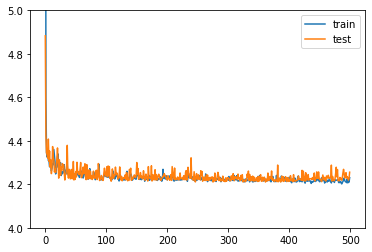

In [161]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.gca().set_ylim(4,5)
plt.show()

In [162]:
regressor.save('1_model.h5')

In [169]:
pred = regressor.predict([X_test[0], X_test[1], X_test[2], X_test[3], X_test[4]])

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


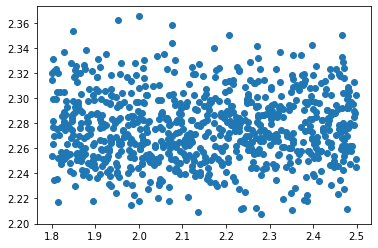

In [179]:
plt.scatter(l_test[:,4], pred[:,4])

In [ ]:
#retrain

model = keras.models.load_model('1_model.h5', compile=False) #load the model from file
modelWeights = model.get_weights()
#modelOptimizer = model.optimizer
model.compile(optimizer = 'adam', loss = "mae") 

#print('lr is ', K.get_session().run(model.optimizer.lr))
epoch=100
epochs=4000
batch_size=200

if os.path.exists('1_model.h5'):
    model.set_weights(modelWeights)
mc = keras.callbacks.ModelCheckpoint("training_checkpoints/cp2.keras", save_best_only=True, save_weights_only=False)

history = model.fit([X_train[0], X_train[1], X_train[2], X_train[3],X_train[4]], l_train, batch_size = batch_size, epochs=epochs, validation_data=([X_test[0], X_test[1], X_test[2], X_test[3], X_test[4]], l_test), callbacks=[mc], initial_epoch=epoch)


Epoch 101/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 4.3068 - val_loss: 4.2524
Epoch 102/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 4.2035 - val_loss: 4.2256
Epoch 103/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 4.2050 - val_loss: 4.2231
Epoch 104/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 4.1918 - val_loss: 4.2216
Epoch 105/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 4.1698 - val_loss: 4.2361
Epoch 106/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - loss: 4.2144 - val_loss: 4.2203
Epoch 107/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 4.1973 - val_loss: 4.2303
Epoch 108/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 4.2063 - val_loss: 4.2354
Epoch 109/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 4.2372 - val_loss: 4.2400
Epoch 110/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 4.2367 - val_loss: 4.2317
Epoch 111/4000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 4.1798 - val_loss: 4.2214
Epoch 112/

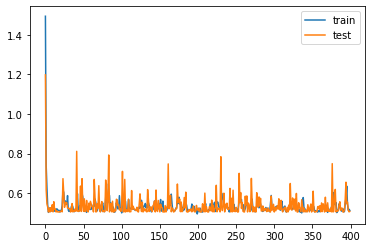

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [50]:
pred_nH = model.predict([X_test[0], X_test[1], X_test[2], X_test[3], X_test[4]])


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


#from sklearn.preprocessing import MinMaxScaler

# Normalize data
#scaler = MinMaxScaler()
#train_data = scaler.fit_transform(train_data)
#test_data = scaler.transform(test_data)
